In [1]:
import pandas as pd
import numpy as np
import sys
from pandas import Series, DataFrame
from datetime import datetime
sys.path.append("../")
from utils import db_utils
from utils import iefp_data_utils
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
import sys
print (sys.path)

['', '/opt/anaconda/lib/python27.zip', '/opt/anaconda/lib/python2.7', '/opt/anaconda/lib/python2.7/plat-linux2', '/opt/anaconda/lib/python2.7/lib-tk', '/opt/anaconda/lib/python2.7/lib-old', '/opt/anaconda/lib/python2.7/lib-dynload', '/opt/anaconda/lib/python2.7/site-packages', '/opt/anaconda/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg', '/opt/anaconda/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/opt/anaconda/lib/python2.7/site-packages/IPython/extensions', '/home/kyang/.ipython', '../']


## Connect to DB and read cascais data tables

In [3]:
conn = db_utils.connect_to_db()
#demo = db_utils.read_table(conn,'iefp','01_municipe')

In [4]:
# read from CSVs for now

municipe = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-01Municípe.csv')
atendimento = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-02Atendimento.csv')
gadi = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-03Gadi.csv')
virar = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-04Virar.csv')
pvp = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-05PVP.csv')
#mentoria = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-06Mentoria.csv')
mentor = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-07Mentor.csv')
epc = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-08EPC.csv')
oficinas = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-09Oficinas.csv')
acasos = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-10Acasos.csv')
poj = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-11POJ.csv')
escolaridade = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-12Escolaridade.csv')
situacaofacetrabalho = pd.read_csv('/mnt/data/shared/workingData/cascais/DPRE_updated-13Situaçãofacetrabalho.csv')

## Clean / map data

In [5]:
municipe.Freguesia.value_counts()

Cascais Estoril               1016
Sao Domingos de Rana           641
Alcabideche                    641
Carcavelos Parede              450
Outra/o Freguesia/Concelho      33
Concelho de Sintra              14
Concelho de Lisboa               8
Concelho de Oeiras               7
Cascais                          1
Mem Martins                      1
Amoreira                         1
Name: Freguesia, dtype: int64

In [6]:
#Make Sexo all lowercase
municipe['Sexo'] = municipe['Sexo'].apply(lambda x: None if pd.isnull(x) else x.lower())

#Map Freguesia to larger buckets
Freg_map = {'Cascais Estoril':'Cascais', 'Cascais': 'Cascais',\
           'Alcabideche':'Alcabideche', 'Amoreira':'Alcabideche',\
           'Sao Domingos de Rana':'Sao Domingos de Rana',
           'Carcavelos Parede': 'Carcavelos Parede',
           'Outra/o Freguesia/Concelho':'Other',\
           'Concelho de Sintra':'Other',\
           'Concelho de Lisboa':'Other',\
           'Mem Martins':'Other', 'Amoreira':'Other'}

municipe['region']=municipe['Freguesia'].map(Freg_map)

In [7]:
municipe.region.value_counts()

Cascais                 1017
Sao Domingos de Rana     641
Alcabideche              641
Carcavelos Parede        450
Other                     57
Name: region, dtype: int64

In [8]:
#check that education and situation tabs have only 1 entry per id
print escolaridade.ID.value_counts().max()
print situacaofacetrabalho.ID.value_counts().max()

1
1


In [9]:
# map education levels
Edu_map = {"02.º ano":"<12",
           "9º ano":"<12",
           '09.º ano':"<12",
           "10.º ano":"<12",
           "06.º ano":"<12",
           "04.º ano":"<12",
           "07.º ano":"<12",
           "08.º ano":"<12",
           "9ºano":"<12",
           "11.º ano":"12",
           '12.º ano geral':'12',
           "12º ano":"12",
           "12.º ano tecnico-profissional":"Bachelors",
           "Bacharelato": "Bachelors",     
           "Curso de especializacao tecnologica":"Bachelors",
           "Licenciatura Servico Social":"Bachelors",
           'Licenciatura':'Bachelors',
           "Mestrado":"Masters+",
           "Pos-graduacao":"Masters+",
           "Doutoramento":"Masters+"
          }
escolaridade['education'] = escolaridade['UltimoDeEscolaridade'].map(Edu_map)

#               1
# Estudante                                1
# t                             1
#                                  1
#                                    1

In [10]:
escolaridade.education.value_counts()

12           1246
Bachelors     834
<12           216
Masters+       92
Name: education, dtype: int64

In [11]:
#map ID to education in municipality tab
edu_dict = dict(zip(escolaridade['ID'], escolaridade['education']))
municipe['education'] = municipe['ID'].astype(str).map(edu_dict)

In [12]:
#education ID error
escolaridade.ID.sort_values(ascending=False).head(20)

2404    ; Estagio Profissional no Centro de Convivio n...
2403    ; Estagio Profissional na Policia Municipal de...
2457    ; Disciplina de Composicao (Secundario) na Esc...
2410             ; Curso de Salvamento e Desencarcerament
2422    ; \tCurso de Ciencias do Esporte – enfase em P...
2421       ; \tCurso Gestao de Futebol da IBMEC/RJ - 2012
2420    ; \tCurso Gestao Esportiva - Universidade Tric...
2419       : Simposio de Direito Esportivo da UFRJ - 2012
1970                                                 9999
1969                                                 9984
1968                                                 9974
1967                                                 9962
1966                                                 9705
1965                                                 9704
1964                                                 9703
1963                                                 9702
1962                                                 9701
1961          

In [13]:
#map ID to situation in municipality tab
situacao_dict = dict(zip(situacaofacetrabalho['ID'], situacaofacetrabalho['Situacao']))
municipe['situation'] = municipe['ID'].map(situacao_dict)

## Filter data to include

In [14]:
#create datetime object for data insertion date

def create_datetime(df, date_column):
    df['insertion_date'] = pd.to_datetime(df[date_column])

df_list = [municipe, atendimento, gadi, virar, pvp, mentor, epc, oficinas, acasos, poj, escolaridade, situacaofacetrabalho]

date_column_list = ['Data de inserção de dados', 'Última data de atendimento', 'Última data de atendimento GADI',\
                   'Última data de atendimento VIRAR', 'Última data de acompanhamento PVP', 'Última data de atendimento Mentor',\
                   'Última data da sessão', 'Última data de atendimento Oficinas', 
                   'Última data de atendimentos ACASOS', 'Última data de atendimento POJ', 'Última data da Escolaridade',\
                   'Última data da Situação face ao trabalho']

#date_column_dict = dict(zip (df_list, date_column_list))
# for df in df_list:
#     create_datetime(df, date_column_list[df_list.index(df)])

# create_datetime(municipe, municipe.columns[1])
# create_datetime(atendimento, 'Última data de atendimento')
# create_datetime(gadi, 'Última data de atendimento GADI')
# create_datetime(virar, 'Última data de atendimento VIRAR')
# create_datetime(pvp, 'Última data de acompanhamento PVP')
# create_datetime(mentor, 'Última data de atendimento Mentor')
# create_datetime(epc, 'Última data da sessão')
# create_datetime(oficinas, 'Última data de atendimento Oficinas')
# create_datetime(acasos, 'Última data de atendimentos ACASOS')
# create_datetime(poj, 'Última data de atendimento POJ')
# create_datetime(escolaridade, 'Última data da Escolaridade')
# create_datetime(situacaofacetrabalho, 'Última data da Situação face ao trabalho')

create_datetime(municipe, 'Data de insercao de dados')
create_datetime(atendimento, 'Ultima data de atendimento')
create_datetime(gadi, 'Ultima data de atendimento GADI')
create_datetime(virar, 'Ultima data de atendimento VIRAR')
create_datetime(pvp, 'Ultima data de acompanhamento PVP')
create_datetime(mentor, 'Ultima data de atendimento Mentor')
create_datetime(epc, 'Ultima data da sessao')
create_datetime(oficinas, 'Ultima data de atendimento Oficinas')
create_datetime(acasos, 'Ultima data de atendimentos ACASOS')
create_datetime(poj, 'Ultima data de atendimento POJ')
create_datetime(escolaridade, 'Ultima data da Escolaridade')
create_datetime(situacaofacetrabalho, 'Ultima data da Situacao face ao trabalho')

In [15]:
for df in df_list:
    print df.columns

Index([u'ID', u'Data de insercao de dados', u'Data de nasscimento', u'Idade',
       u'Sexo', u'Portador de deficiencia', u'deficiencia', u'Morada',
       u'Localidade', u'CP', u'Freguesia', u'Nacionalidade', u'Naturalidade',
       u'Possui carta de conducao',
       u'Autoriza a utilizacao dos seus dados pessoais para divulgacao de outras iniciativas da DPRE',
       u'Nao autoriza a utilizacao dos seus dados pessoais para divulgacao de outras iniciativas da DPRE',
       u'region', u'education', u'situation', u'insertion_date'],
      dtype='object')
Index([u'ID', u'Ultima data de atendimento', u'Tipo de atendimento',
       u'Informacao sobre A Dois', u'Informacao sobre EPC',
       u'Informacao sobre GADI', u'Informacao sobre Oficinas',
       u'Informacao sobre POJ', u'Informacao sobre PVP',
       u'Informacao sobre Virar', u'Informacao sobre Outro',
       u'Informacao sobre Outro - Qual', u'Inscricao em A Dois',
       u'Inscricao em EPC', u'Inscricao em GADI', u'Inscricao em

In [16]:
# identify IDs that were in 2016 or 2017, or was active in a program in 2016 or 2017
id_include = []
for df in df_list:
    id_include.extend(df[df['insertion_date']>pd.to_datetime('2016-01-01')].ID.tolist())

# get rid of duplicates
id_include = list(set(id_include))

In [17]:
#show number of users in municipe by year (not including other tabs)
municipe.insertion_date.apply(lambda x: x.year).value_counts().sort_index()

1992.0      1
1993.0      1
1994.0      1
2009.0      1
2010.0      4
2011.0     20
2012.0    335
2013.0    479
2014.0    382
2015.0    330
2016.0    828
2017.0    318
Name: insertion_date, dtype: int64

In [18]:
#show number of interactions with ids to include
interactions=[]
for df in df_list:
    interactions.append(len(df))
print sum(interactions)

interaction_include=[]
for df in df_list:
    interaction_include.append(len(df[df['insertion_date']>pd.to_datetime('2016-01-01')]))
print sum(interaction_include)

10555
4046


In [19]:
#filter out from demographics table
print len(municipe)
print len(municipe[municipe['ID'].isin(id_include)])
municipe_clean = municipe[municipe['ID'].isin(id_include)]

3437
1534


## Cascais demographics histograms

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


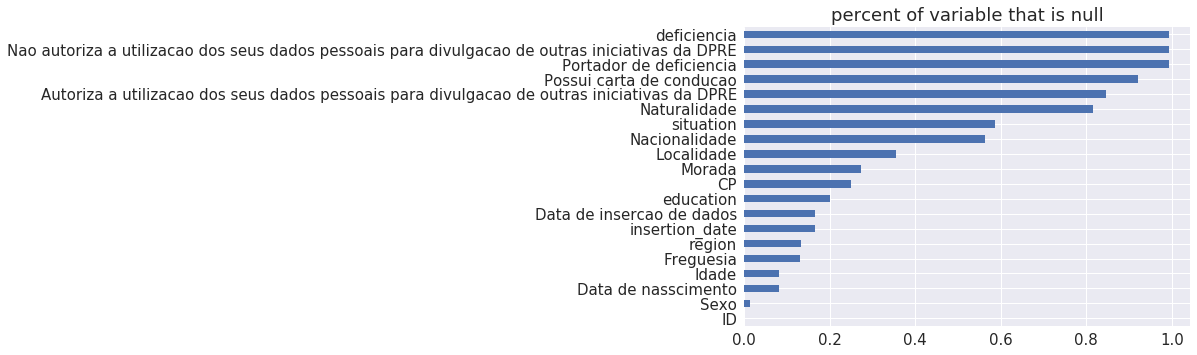

In [20]:
#null analysis
plt.figure()
municipe_clean.isnull().mean().sort_values().plot(kind='barh')
plt.title('percent of variable that is null')

In [21]:
DataFrame(municipe_clean.columns)

,0
0,ID
1,Data de insercao de dados
2,Data de nasscimento
3,Idade
4,Sexo
5,Portador de deficiencia
6,deficiencia
7,Morada
8,Localidade
9,CP


In [22]:
municipe_clean.education.value_counts()

Bachelors    552
12           456
<12          155
Masters+      62
Name: education, dtype: int64

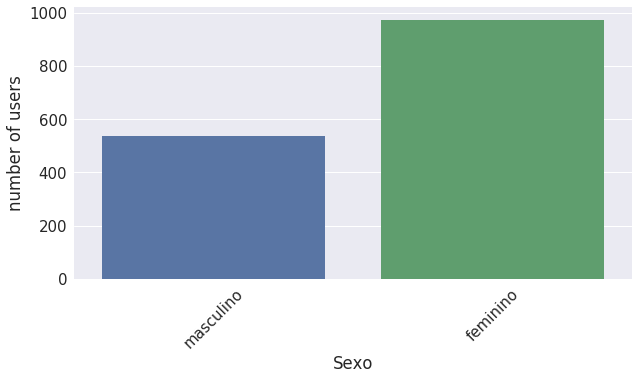

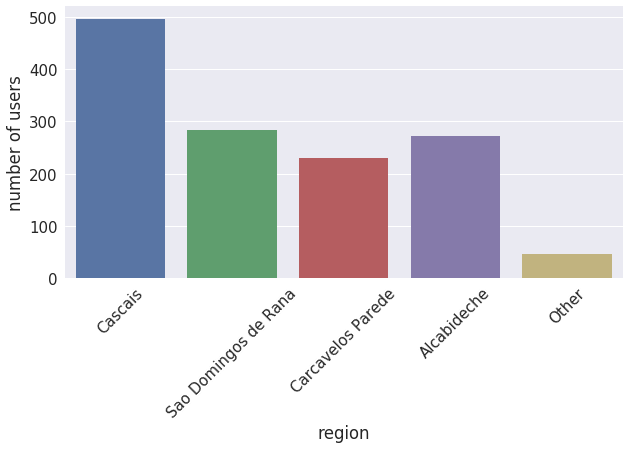

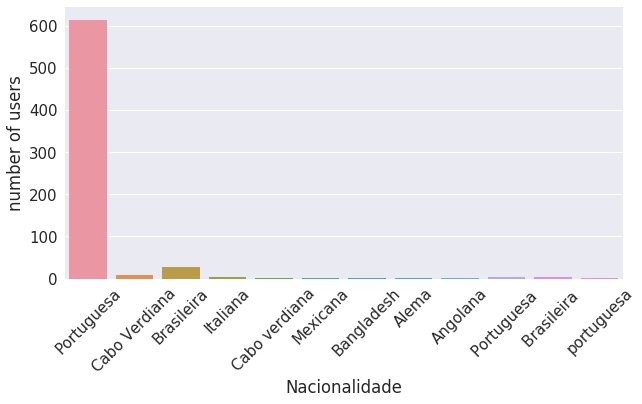

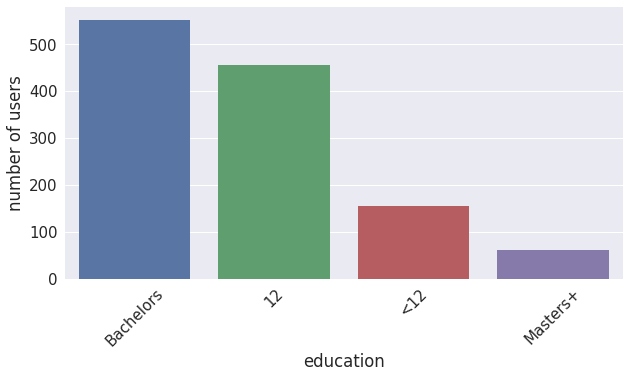

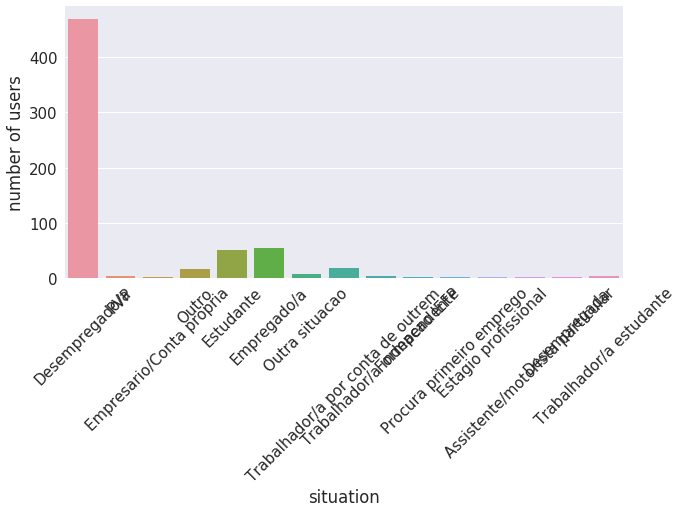

In [23]:
def simple_countplot(df, column):
    plt.figure(figsize=(10,5))
    #municipe_clean[column].hist()
    sns.countplot(x=column, data=df)
    plt.ylabel('number of users')
    plt.xticks(rotation=45)
    plt.show()

for column in ["Sexo", "region", "Nacionalidade",\
               "education", "situation"]:
   simple_countplot(municipe_clean, column)

# age_plot = sns.countplot(x='Idade', data=municipe_clean)
# for label in age_plot.axis.get_ticklabels()[::5]:
#     label.set_visible(False)

/opt/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


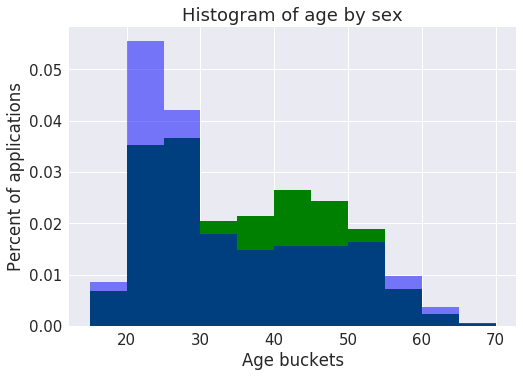

In [24]:
# plot histogram of age by sex
fig = plt.figure()
ax = fig.add_subplot()
plt.title('Histogram of age by sex')
plt.xlabel('Age buckets')
plt.ylabel('Percent of applications')
municipe_clean[municipe_clean['Sexo']=='feminino'].Idade.hist(ax=ax, bins = 11, range = [15,70], normed=True, color='green', alpha=1.0)
municipe_clean[municipe_clean['Sexo']=='masculino'].Idade.hist(ax=ax, bins = 11, range = [15,70], normed=True, color='blue', alpha=0.5)
plt.legend()

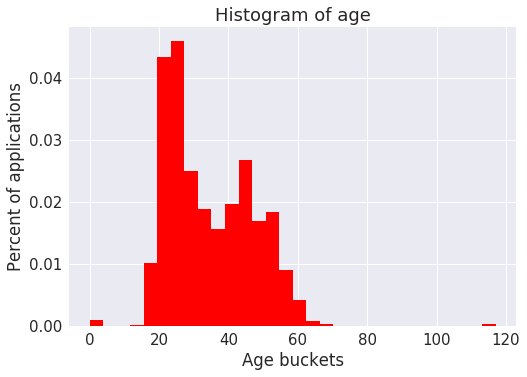

In [25]:
# plot histogram of age
fig = plt.figure()
ax = fig.add_subplot()
plt.title('Histogram of age')
plt.xlabel('Age buckets')
plt.ylabel('Percent of applications')
municipe_clean.Idade.hist(ax=ax, bins = 30, normed=True, color='red', alpha=1.0)

In [26]:
# # histogram of male age for each region

# def age_hist(df, sex, region):
#     fig = plt.figure()
#     ax = fig.add_subplot()
#     plt.title(str(sex)+' age histogram for '+str(region))
#     plt.xlabel('Age buckets')
#     plt.ylabel('Percent of applications')
#     df[(df['region']==region) &\
#                   (df['Sexo']==sex)].Idade.hist(ax=ax, bins = 11, range = [15,70], normed=True, color='red', alpha=1.0)
#     df.Idade.hist(ax=ax, bins = 11, range = [15,70], normed=True, color='blue', alpha=0.5)
#     plt.show()

# for region in municipe_clean.region:
#     for sex in municipe_clean.Sexo:
#         age_hist(municipe_clean, sex, region)

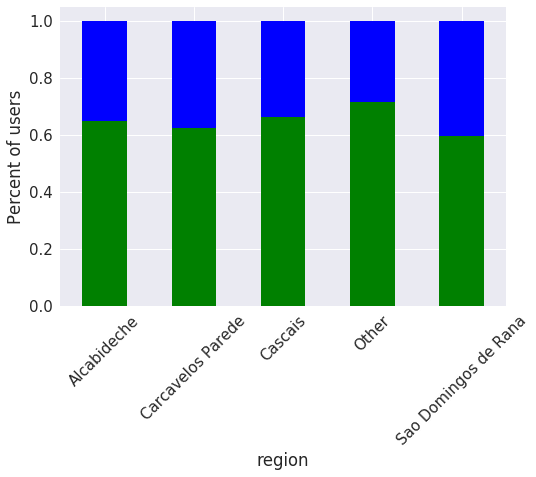

In [27]:
#gender breakdown by region
plt.figure()
municipe_clean.groupby('region').Sexo.value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, \
                                                                                  color=['green', 'blue'], legend=False)
plt.xticks(rotation=45)
plt.ylabel('Percent of users')

## Histograms using education and situation tables

In [28]:
escolaridade_clean = escolaridade[escolaridade['ID'].isin(id_include)]
situacao_clean = situacaofacetrabalho[situacaofacetrabalho['ID'].isin(id_include)]

In [29]:
#simple_countplot(escolaridade_clean, 'UltimoDeEscolaridade')

In [30]:
situacao_clean.Situacao.value_counts()

Desempregado/a                       469
Empregado/a                           55
Estudante                             51
Trabalhador/a por conta de outrem     18
Outro                                 16
Outra situacao                         8
PVP                                    4
Trabalhador/a estudante                4
Trabalhador/a independente             3
Procura primeiro emprego               2
Empresario/Conta propria               1
Formacao IEFP                          1
Desempregada                           1
Estagio profissional                   1
Assistente/motorista particular        1
Name: Situacao, dtype: int64

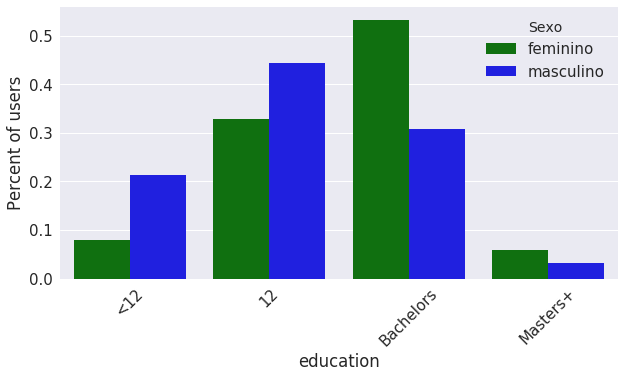

In [31]:
#gender breakdown by education level
edu_order = ['<12', '12', 
            'Bachelors', 'Masters+']


plt.figure(figsize = (10,5))
#sns.countplot(x='education', hue='Sexo', order=edu_order, data=municipe_clean)
#sns.barplot(y='education',hue='Sexo', data=edu_sexo)


edu_sexo = DataFrame(municipe_clean.groupby('Sexo')['education']\
.value_counts(normalize=True))
edu_sexo.columns = ['percent']
edu_sexo.reset_index(level=['Sexo', 'education'], inplace=True)
sns.barplot(x='education',y='percent',hue='Sexo', data=edu_sexo, order=edu_order,\
           palette={'masculino':'blue', 'feminino':'green'})
plt.xticks(rotation=45)
plt.ylabel('Percent of users')

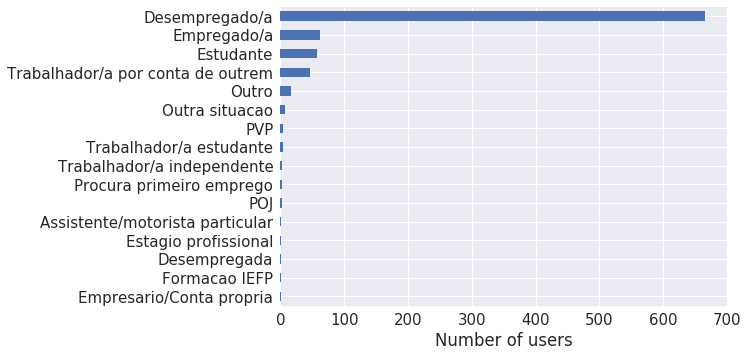

In [32]:
#Situation
municipe.situation.value_counts().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of users')

In [33]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Education plots from IEFP data to compare

In [34]:
apps_df = pd.read_sql('select * from cascais_v2.application', con=conn)



In [66]:
# create english education levels
eng_edu = {'11': '12', '12': '12', '04': '<12', '06': '<12', '09':'<12',
          'BM': 'Bachelors', 'DT': 'doctoral', 'PS': 'Masters+',
          'SL': '<12', 'LC': 'Bachelors',
          'MT': 'Masters+', 'NS': '<12'}
apps_df.loc[:, 'education'] = apps_df['chabilitacao_escolar'].map(eng_edu)

# create english categories
eng_category = {'DESEMPREGADO-NOVO EMPREGO': 'Unemployed - new job',
          'DESEMPREGADO-1Âº EMPREGO': 'Unemployed - first job',
          'EMPREGADO': 'Employed',
          'EMPREGADO A TEMPO PARCIAL':'Part-time employed'}
apps_df.loc[:, 'category'] = apps_df['dcategoria'].map(eng_category)

# filter for only unemployed
apps_unemp = apps_df[apps_df['dcategoria'].apply(lambda x: x[0:3]==('DES'))]
len(apps_unemp)

119926

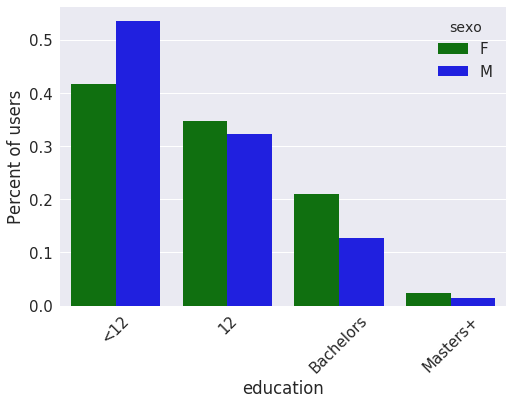

In [67]:
# sns.countplot(x='education', hue='sexo', order=edu_order, data=apps_df)
# plt.xticks(rotation=45)
plt.figure()
iefp_edu = DataFrame(apps_unemp.groupby('sexo')['education']\
.value_counts(normalize=True))
iefp_edu.columns = ['percent']
iefp_edu.reset_index(level=['sexo', 'education'], inplace=True)
sns.barplot(x='education',y='percent',hue='sexo', data=iefp_edu, order=edu_order,\
           palette={'M':'blue', 'F':'green'})
plt.xticks(rotation=45)
plt.ylabel('Percent of users')

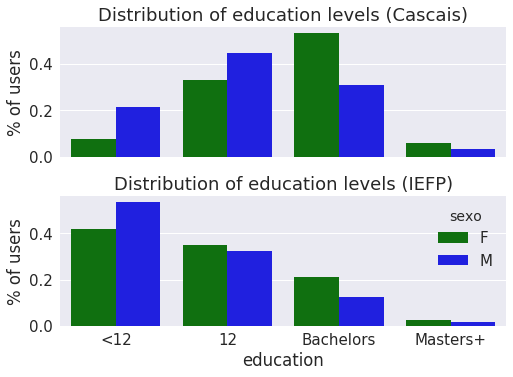

In [68]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.3)

sns.barplot(x='education',y='percent',hue='Sexo', data=edu_sexo, order=edu_order,\
           palette={'masculino':'blue', 'feminino':'green'}, ax=ax1)
ax1.set_ylabel('% of users')
ax1.set_title('Distribution of education levels (Cascais)')
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)

sns.barplot(x='education',y='percent',hue='sexo', data=iefp_edu, order=edu_order,\
           palette={'M':'blue', 'F':'green'}, ax=ax2)
ax2.set_ylabel('% of users')
ax2.set_title('Distribution of education levels (IEFP)')